In [ ]:
import pandas as pd
import numpy as np
# import pyneb as pn
# import ChiantiPy.core as ch

from scipy.io import FortranFile
from scipy.interpolate import RegularGridInterpolator, interp1d
import cutout_utils as cu

""" Physical Constants """
clight  = 2.99792458e10          #[cm/s] light speed
kb      = 1.38064852e-16         #[erg/K] Boltzman constant
mp      = 1.672621898e-24        #[g] proton mass
planck  = 6.626070040e-27        #[erg s] Planck's constant
avogad  = 6.0221409e23           #[1/mol] Avogadro's number
X_H     = 0.76
Y_He    = 1.0 - X_H
mhe     = 6.6464731e-24
lsun    = 3.826e33               #[erg/s] solar luminosity
pc_to_cm = 3.086e+18             #parsecs to cm
ev_to_erg = 1.60218e-12          # Electron volts to ergs

# element weights [g]
element_weights = {
    'C': 12.011,
    'Fe': 55.847,
    'H': 1.00797,
    'He': 4.00260,
    'Mg': 24.305,
    'N': 14.0067,
    'Ne': 20.179,
    'O': 15.9994,
    'S': 32.06,
    'Si': 28.0855,
}
for key in element_weights:
    element_weights[key] = element_weights[key]/avogad

def read_megatron_cutout(ff,lmax=20.0):
    """
    Function to read in a megatron gas cutout
    """

    header = [
        "redshift",
        "dx",
        "x", "y", "z",
        "vx", "vy", "vz",
        "nH", "T", "P",
        "nFe", "nO", "nN", "nMg", "nNe", "nSi", "nCa", "nC", "nS", "nCO",
        "O_I", "O_II", "O_III", "O_IV", "O_V", "O_VI", "O_VII", "O_VIII",
        "N_I", "N_II", "N_III", "N_IV", "N_V", "N_VI", "N_VII",
        "C_I", "C_II", "C_III", "C_IV", "C_V", "C_VI",
        "Mg_I", "Mg_II", "Mg_III", "Mg_IV", "Mg_V", "Mg_VI", "Mg_VII", "Mg_VIII", "Mg_IX", "Mg_X",
        "Si_I", "Si_II", "Si_III", "Si_IV", "Si_V", "Si_VI", "Si_VII", "Si_VIII", "Si_IX", "Si_X", "Si_XI",
        "S_I", "S_II", "S_III", "S_IV", "S_V", "S_VI", "S_VII", "S_VIII", "S_IX", "S_X", "S_XI",
        "Fe_I", "Fe_II", "Fe_III", "Fe_IV", "Fe_V", "Fe_VI", "Fe_VII", "Fe_VIII", "Fe_IX", "Fe_X", "Fe_XI",
        "Ne_I", "Ne_II", "Ne_III", "Ne_IV", "Ne_V", "Ne_VI", "Ne_VII", "Ne_VIII", "Ne_IX", "Ne_X",
        "H_I", "H_II", "He_II", "He_III",
        "Habing", "Lyman_Werner", "HI_Ionising", "H2_Ionising", "HeI_Ionising", "HeII_ionising"
        ]

    # load in all of the quantities from the cutout
    for i,q in enumerate(header):
        # Read in the quantity
        dat = ff.read_reals("float64")

        # If first iteration create the data array
        if i == 0:
            all_dat = np.zeros((len(dat),len(header)))

        all_dat[:,i] = dat

    # Now create the pandas array
    df = pd.DataFrame(all_dat, columns=header)

    # Now compute some extra properties
    cell_mass = 1.6735575e-24 * ((10.0**df["nH"])/0.76) * ((10.**df["dx"])**3) / 1.9891e33
    df["mass"] = cell_mass

    # Compute the electron density
    edens = (10.**df["nH"]) * df["H_II"]  # Hydrogen
    edens += ((0.24*(10.**df["nH"])/0.76)/4.0) * (df["He_II"] + 2.0 * df["He_III"]) # Helium
    metals = ["C","N","O","Ne","Mg","Si","S","Fe"]
    roman_nums = ["I","II","III","IV","V","VI","VII","VIII","IX","X","XI","XII"]
    for m in metals:
        for i,r in enumerate(roman_nums):
            key = f"{m}_{r}"
            if key in df.keys():
                edens += (10.**df[f"n{m}"]) * (df[key]*i)
    df["ne"] = edens

    # Compute the level for each cell
    level = np.rint(lmax - np.log2((10.0**df["dx"])/(10.0**min(df["dx"])))).astype(int)
    df["level"] = level

    # get the helium number density for each cell
    df["nHe"] = np.log10(((0.24*(10.**df["nH"])/0.76)/4.0))

    # Finally get the depletions
    dep_table = get_all_dust_depletions(df["nH"],df["nO"],df["T"])

    # Append the depletions
    df = pd.concat([df, dep_table], axis=1)

    # Make H and He dep 1
    df["H_dep"] = 1.0
    df["He_dep"] = 1.0

    return df

def isotropic_direction_fast(n):
    """ Computes a normalized vector with an isotropic direction

    Harley ported this from rascas
    """
    phi   = 2.0 * np.pi * np.random.random(n)
    cos_theta = 1.0 - 2.0 * np.random.random(n)  # in [-1,1]
    sin_theta = np.sqrt(1.0 - cos_theta**2) # in [0,1]

    k = np.zeros((n,3))
    k[:,0] = sin_theta * np.cos(phi)
    k[:,1] = sin_theta * np.sin(phi)
    k[:,2] = cos_theta

    # force normalisation at numerical precision
    knorm = np.sqrt((k**2).sum(axis=1))
    k     = k / knorm[:, np.newaxis]

    return k

def output_data_to_ics(n_photons, n_real_phot, photon_ids, photon_nu_ext,
                       photon_pos, photon_dirs, photon_seeds, photon_vel,
                       output_file_name):
    """ Outputs the data to an ICs file that can be read
    by rascas
    """

    try:
        f = FortranFile(output_file_name, 'w')
        f.write_record(np.int32(n_photons))                          # Number of photons
        f.write_record(np.float64(n_real_phot))                      # Number of real photons (per sec).
        f.write_record(np.int32(42))                                 # Random seed
        f.write_record(photon_ids.astype(np.int64))                  # IDs
        f.write_record(photon_nu_ext.astype(np.float64))             # Frequency (external frame)
        f.write_record(photon_pos.astype(np.float64))                # Positions
        f.write_record(photon_dirs.astype(np.float64))               # Initial directions
        f.write_record(photon_seeds.astype(np.int32))                # Seeds
        f.write_record(photon_vel.astype(np.float64))                # Velovity of source 
        f.close()

        return True
    except Exception as e:
        print(f"Error saving ICs file with error: {e}")
        return False

"""
EXAMPLE CODE IS BELOW HERE
"""

# Load in the halo cutout
ff = FortranFile("../../dataset_examples/halo_3517_gas.bin")
df_gas = cu.read_megatron_cutout(ff)

# Get the Mg II luminosity in each cell

nH   = 10**df_gas["nH"].values          # total hydrogen number density [cm^-3]
T    = 10**df_gas["T"].values           # temperature [K]
ne   = df_gas["ne"].values              # electron density [cm^-3]
xHII = df_gas["H_II"].values            # ionized hydrogen fraction
xHI  = df_gas["H_I"].values             # neutral hydrogen fraction
nHII = nH * xHII                        # ionized hydrogen density [cm^-3]
nHI  = nH * xHI                         # neutral hydrogen density [cm^-3]

# Case B recombination coefficient (Hui & Gnedin 1997)
alphaB = 2.59e-13 * (T / 1e4)**-0.7   # [cm^3 s^-1]

# Lyman-alpha photon energy
E_lya = 10.2 * 1.60218e-12  # erg

# --- Step 3: Compute emissivities ---
# Recombination
emis_rec = ne * nHII * alphaB * E_lya   # [erg cm^-3 s^-1]

# Collisional excitation (Katz+ 2022, Appendix A)
a, b, c, d = 6.58e-18, 4.86e4, 0.185, 0.895
epsilon_coll = a / (T**c) * np.exp(-b / (T**d))
emis_coll = ne * nHI * epsilon_coll     # [erg cm^-3 s^-1]
dx = 10**df_gas["dx"].values
L_Lya = (emis_rec + emis_coll) * dx**3  # [erg/s]
print(f"Sum L_Lya = {L_Lya.sum()/lsun:.2e} L☀️")

# Define the number of photons
N_PHOT = 10000
cell_phot = np.random.multinomial(N_PHOT, L_Lya / L_Lya.sum())
N_PHOT = cell_phot.sum()   # ensure consistency

# --- Uniformly distribute photons within each cell ---
cell_centers = df_gas[["x","y","z"]].values
cell_sizes = dx.copy().reshape(-1,1)
photon_cell_pos_centers = np.repeat(cell_centers, cell_phot, axis=0)
photon_cell_dx = np.repeat(cell_sizes, cell_phot, axis=0)
random_offsets = (np.random.random(photon_cell_pos_centers.shape) - 0.5) * photon_cell_dx
photon_cell_pos  = photon_cell_pos_centers + random_offsets
# --- Velocities ---
photon_cell_vel = np.repeat(df_gas[["vx","vy","vz"]].values, cell_phot, axis=0)

# --- Frequencies ---
sigma_v = np.sqrt(2.0 * kb * (10.0**df_gas["T"].values) / element_weights["H"])  # [cm/s]
sigma_v = np.repeat(sigma_v, cell_phot)  # expand to photon level
nu0 = clight / (1215.67e-8)
nu_cell = np.random.normal(loc=nu0, scale=nu0 * sigma_v / clight)

# --- Directions ---
photon_directions = isotropic_direction_fast(N_PHOT)

print(f"Successfully assigned {N_PHOT} photons to cells ✅")
# --- Convert to external frame ---
scalar = (photon_cell_vel * photon_directions).sum(axis=1)
nu_ext = nu_cell / (1.0 - (scalar / clight))

# --- Output ICs ---
output_data_to_ics(
    N_PHOT,
    L_Lya.sum() / (planck * clight / (1215.67e-8)), 
    np.arange(N_PHOT)+1,
    nu_ext,
    photon_cell_pos, 
    photon_directions, 
    np.arange(N_PHOT)+1, 
    photon_cell_vel,
    "../DATA/test_rascas_Lya_ics.bin"
)
print("Successfully wrote ICs file ✅")


KeyboardInterrupt: 

# ion density

-----> reading mesh in file  ../domdump/domain_1.mesh
-----> domain
domain type = sphere
domain size = [0.00052]
domain center = [0.49795532 0.50045776 0.51189804]
-----> mesh
ncoarse = 1
noct    = 104300
ncell   = 834401
nleaf   = 723686
INFO father    (104300,) 1 834344
INFO son       (834401,) -723686 104300
INFO nbor      (6, 104300) 1 834378
INFO octlevel  (104300,) 1 20
INFO xoct      (3, 104300) 0.25 0.75
-----> gas
INFO gas v: (723686, 3) -399991802.5787107 332961916.47777176
INFO gas nion: (723686,) 2.3534614292942365e-14 67897.39349103207
INFO gas dopwidth: (723686,) 583344156.7635226 5.935055759055031e+16
INFO gas vturb: (723686,) 2000000.0 2000000.0
INFO gas ndust: (723686,) 0.0 13353.738716752783
boxsize [cm] = 2.292037440672e+25
-----> get xleaf
INFO dx:    (723686,) 9.5367431640625e-07 6.103515625e-05
INFO xleaf: (3, 723686) 0.4974212646484375 0.5124359130859375
-----> get leaf level
INFO cell_level: (723686,) 14 20
-----> reading done.

positions: (723686, 3)
levels: (7

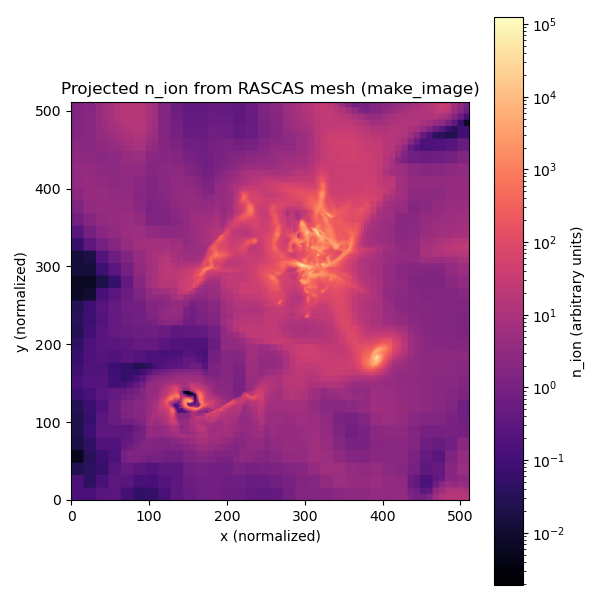

In [9]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


# RASCAS py modules
sys.path.append("../../py")
import mesh as me
import domain as d
%matplotlib widget

# Your imaging utilities
import cutout_utils as cu   # or whatever name the file has

# 1️⃣ Load the domain
mesh_file = "../domdump/domain_1.mesh"
mdom = me.mesh(filename=mesh_file, gasmix="new_ions", Silent=False)

# 2️⃣ Extract arrays
positions = np.array(mdom.gas.xleaf).T     # (N, 3)
levels    = np.array(mdom.gas.leaflevel)
features  = np.array(mdom.gas.nion)
dx        = 1.0 / (2.0 ** levels)          # normalized cell size

print("positions:", positions.shape)
print("levels:", levels.shape)
print("features:", features.shape)

# 3️⃣ Make image
image, _ = cu.make_image(
    positions,
    levels,
    features,
    dx,
    view_dir='z',
    npix=512,
    lmin=np.min(levels),
    lmax=np.max(levels),
    redshift=0.0,
    boxsize=1.0
)

# 4️⃣ Plot
plt.figure(figsize=(6,6))
plt.imshow(image, norm=LogNorm(), cmap='magma', origin='lower')
plt.colorbar(label='n_ion (arbitrary units)')
plt.xlabel('x (normalized)')
plt.ylabel('y (normalized)')
plt.title('Projected n_ion from RASCAS mesh (make_image)')
plt.gca().add_collection(d.overplot_limits(mdom.domain, color='white', linewidth=1))
plt.tight_layout()
plt.show()


# HI

-----> reading mesh in file  ../domdump/domain_1.mesh
-----> domain
domain type = sphere
domain size = [0.00052]
domain center = [0.49795532 0.50045776 0.51189804]
-----> mesh
ncoarse = 1
noct    = 104300
ncell   = 834401
nleaf   = 723686
INFO father    (104300,) 1 834344
INFO son       (834401,) -723686 104300
INFO nbor      (6, 104300) 1 834378
INFO octlevel  (104300,) 1 20
INFO xoct      (3, 104300) 0.25 0.75
-----> gas
INFO gas v: (723686, 3) -399991802.5787107 332961916.47777176
INFO gas nHI: (723686,) 2.3534614292942365e-14 67897.39349103207
INFO gas dopwidth: (723686,) 583344156.7635226 5.935055759055031e+16
DEBUG boxsize values read = [2000000. 2000000. 2000000. ... 2000000. 2000000. 2000000.]
boxsize [cm] = 2000000.0
-----> get xleaf
INFO dx:    (723686,) 9.5367431640625e-07 6.103515625e-05
INFO xleaf: (3, 723686) 0.4974212646484375 0.5124359130859375
-----> get leaf level
INFO cell_level: (723686,) 14 20
-----> reading done.

positions: (723686, 3)
levels: (723686,)
features:

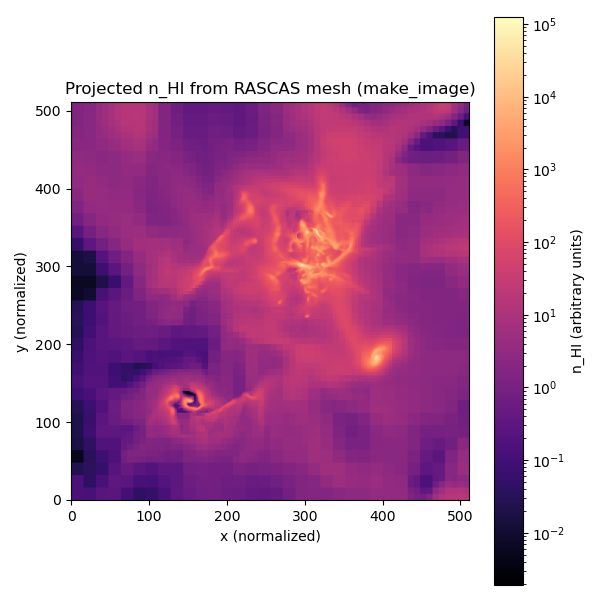

In [8]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


# RASCAS py modules
sys.path.append("../../py")
import mesh as me
import domain as d
%matplotlib widget

# Your imaging utilities
import cutout_utils as cu   # or whatever name the file has

# 1️⃣ Load the domain
mesh_file = "../domdump/domain_1.mesh"
mdom = me.mesh(filename=mesh_file, gasmix="HI", Silent=False)

# 2️⃣ Extract arrays
positions = np.array(mdom.gas.xleaf).T     # (N, 3)
levels    = np.array(mdom.gas.leaflevel)
features  = np.array(mdom.gas.nhi)
dx        = 1.0 / (2.0 ** levels)          # normalized cell size

print("positions:", positions.shape)
print("levels:", levels.shape)
print("features:", features.shape)

# 3️⃣ Make image
image, _ = cu.make_image(
    positions,
    levels,
    features,
    dx,
    view_dir='z',
    npix=512,
    lmin=np.min(levels),
    lmax=np.max(levels),
    redshift=0.0,
    boxsize=1.0
)

# 4️⃣ Plot
plt.figure(figsize=(6,6))
plt.imshow(image, norm=LogNorm(), cmap='magma', origin='lower')
plt.colorbar(label='n_HI (arbitrary units)')
plt.xlabel('x (normalized)')
plt.ylabel('y (normalized)')
plt.title('Projected n_HI from RASCAS mesh (make_image)')
plt.gca().add_collection(d.overplot_limits(mdom.domain, color='white', linewidth=1))
plt.tight_layout()
plt.show()


-----> reading mesh in file  ../domdump/domain_1.mesh
-----> domain
domain type = sphere
domain size = [0.00052]
domain center = [0.49795532 0.50045776 0.51189804]
-----> mesh
ncoarse = 1
noct    = 104300
ncell   = 834401
nleaf   = 723686
INFO father    (104300,) 1 834344
INFO son       (834401,) -723686 104300
INFO nbor      (6, 104300) 1 834378
INFO octlevel  (104300,) 1 20
INFO xoct      (3, 104300) 0.25 0.75
-----> gas
INFO gas v: (723686, 3) -399991802.5787107 332961916.47777176
INFO gas nHI: (723686,) 2.3534614292942365e-14 67897.39349103207
INFO gas dopwidth: (723686,) 583344156.7635226 5.935055759055031e+16
DEBUG boxsize values read = [2000000. 2000000. 2000000. ... 2000000. 2000000. 2000000.]
boxsize [cm] = 2000000.0
-----> get xleaf
INFO dx:    (723686,) 9.5367431640625e-07 6.103515625e-05
INFO xleaf: (3, 723686) 0.4974212646484375 0.5124359130859375
-----> get leaf level
INFO cell_level: (723686,) 14 20
-----> reading done.



ValueError: object too deep for desired array

-----> reading mesh in file  ../domdump/domain_1.mesh
-----> domain
domain type = sphere
domain size = [0.00052]
domain center = [0.49795532 0.50045776 0.51189804]
-----> mesh
ncoarse = 1
noct    = 104300
ncell   = 834401
nleaf   = 723686
INFO father    (104300,) 1 834344
INFO son       (834401,) -723686 104300
INFO nbor      (6, 104300) 1 834378
INFO octlevel  (104300,) 1 20
INFO xoct      (3, 104300) 0.25 0.75
-----> gas
INFO gas v: (723686, 3) -399991802.5787107 332961916.47777176
INFO gas nHI: (723686,) 2.3534614292942365e-14 67897.39349103207
INFO gas dopwidth: (723686,) 583344156.7635226 5.935055759055031e+16
DEBUG boxsize values read = [2000000. 2000000. 2000000. ... 2000000. 2000000. 2000000.]
boxsize [cm] = 2000000.0
-----> get xleaf
INFO dx:    (723686,) 9.5367431640625e-07 6.103515625e-05
INFO xleaf: (3, 723686) 0.4974212646484375 0.5124359130859375
-----> get leaf level
INFO cell_level: (723686,) 14 20
-----> reading done.

2.3534614292942365e-14 67897.39349103207


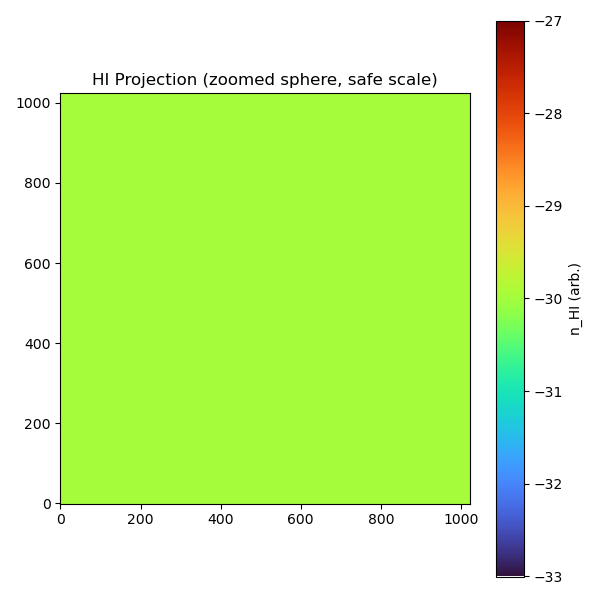

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mesh import mesh
from maps import make_map

# --- Load domain ---
mdom = mesh(filename="../domdump/domain_1.mesh", gasmix="HI", Silent=False)

positions = np.array(mdom.gas.xleaf)
levels    = np.array(mdom.gas.leaflevel)
nHI       = np.array(mdom.gas.nhi)

features = nHI
print(nHI.min(), nHI.max())


image, _ = make_map(
    lmax = 9,                      # lower = larger pixels (covers sphere)
    positions = positions,
    levels = levels,
    features = features,
    xmin = 0, xmax = 1,
    ymin = 0, ymax = 1,
    zmin = 0, zmax = 1,
    view_dir = "z",
)

# --- Safe plotting ---
plt.figure(figsize=(6,6))
# positive = image[image > 0]
# if len(positive) == 0:
#     print("⚠️ No nonzero pixels — try increasing r or lowering lmax.")
#     vmin, vmax = 1e-30, 1e-20
# else:
#     vmin = np.percentile(positive, 1)
#     vmax = np.percentile(positive, 99)

im = plt.imshow(
    image,
    origin="lower",
    cmap="turbo",
    # norm=colors.LogNorm(vmin=vmin, vmax=vmax)
)
im = plt.imshow(np.log10(image + 1e-30), origin="lower", cmap="turbo")
plt.colorbar(im, label="n_HI (arb.)")
plt.title("HI Projection (zoomed sphere, safe scale)")
plt.tight_layout()
plt.show()


-----> reading mesh in file  ../domdump/domain_1.mesh
-----> domain
domain type = sphere
domain size = [0.00052]
domain center = [0.49795532 0.50045776 0.51189804]
-----> mesh
ncoarse = 1
noct    = 104300
ncell   = 834401
nleaf   = 723686
INFO father    (104300,) 1 834344
INFO son       (834401,) -723686 104300
INFO nbor      (6, 104300) 1 834378
INFO octlevel  (104300,) 1 20
INFO xoct      (3, 104300) 0.25 0.75
-----> gas
INFO gas v: (723686, 3) -399991802.5787107 332961916.47777176
INFO gas nHI: (723686,) 2.3534614292942365e-14 67897.39349103207
INFO gas dopwidth: (723686,) 583344156.7635226 5.935055759055031e+16
DEBUG boxsize values read = [2000000. 2000000. 2000000. ... 2000000. 2000000. 2000000.]
boxsize [cm] = 2000000.0
-----> get xleaf
INFO dx:    (723686,) 9.5367431640625e-07 6.103515625e-05
INFO xleaf: (3, 723686) 0.4974212646484375 0.5124359130859375
-----> get leaf level
INFO cell_level: (723686,) 14 20
-----> reading done.

nHI range: 2.3534614292942365e-14 67897.3934910320

/var/folders/b_/pqktl48d3n99fxjn7q_z7pvm0000gn/T/ipykernel_50477/1614038936.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r = float(mdom.domain.radius) * 10.0   # zoom box around the sphere


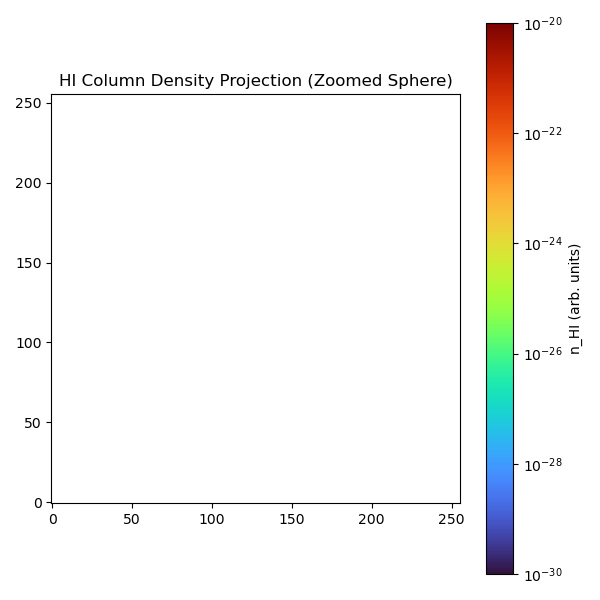

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mesh import mesh
from maps import make_map

# --- Load domain ---
mdom = mesh(filename="../domdump/domain_1.mesh", gasmix="HI", Silent=False)

positions = np.array(mdom.gas.xleaf)
levels    = np.array(mdom.gas.leaflevel)
nHI       = np.array(mdom.gas.nhi)

print("nHI range:", nHI.min(), nHI.max())

# --- Define zoom region ---
c = mdom.domain.center
r = float(mdom.domain.radius) * 10.0   # zoom box around the sphere

image, _ = make_map(
    lmax = 8,                      # 256×256 pixels
    positions = positions,
    levels = levels,
    features = nHI,
    xmin = c[0] - r, xmax = c[0] + r,
    ymin = c[1] - r, ymax = c[1] + r,
    zmin = c[2] - r, zmax = c[2] + r,
    view_dir = "z",
)

# --- Plot ---
plt.figure(figsize=(6,6))
positive = image[image > 0]
if len(positive) > 0:
    vmin = np.percentile(positive, 1)
    vmax = np.percentile(positive, 99)
else:
    vmin, vmax = 1e-30, 1e-20
print("Plot vmin, vmax)
plt.imshow(
    image,
    origin="lower",
    cmap="turbo",
    norm=colors.LogNorm(vmin=vmin, vmax=vmax)
)
plt.colorbar(label="n_HI (arb. units)")
plt.title("HI Column Density Projection (Zoomed Sphere)")
plt.tight_layout()
plt.show()
